In [1]:
# Code from Book: Build Your Own AI Investor
# Damon Lee 2020
# Check out the performance on www.valueinvestingai.com
# Code uses data from the (presumably) nice people at https://simfin.com/. 
# Feel free to fork this code for others to see what can be done with it.

import pandas as pd
import numpy as np
import math
import pickle # get the ML model from other notebook
from matplotlib import pyplot as plt # scatter plot
import matplotlib.lines as mlines # plot

In [2]:
from platform import python_version
print(python_version())

3.9.7


In [3]:
x=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios.csv", index_col=0)
yperf=pd.read_csv("Annual_Stock_Price_Performance_Percentage.csv", index_col=0)
yperf=yperf["Perf"]

In [4]:
X_train=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_train.csv", index_col=0)
X_test=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_test.csv", index_col=0)
y_train=pd.read_csv("Annual_Stock_Price_Performance_Percentage_train.csv", index_col=0)
y_test=pd.read_csv("Annual_Stock_Price_Performance_Percentage_test.csv", index_col=0)

In [5]:
# DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

pl_decTree = Pipeline([
    ('DecisionTreeRegressor', DecisionTreeRegressor(random_state=42, max_depth=9))
])

pl_decTree.fit(X_train, y_train)
y_pred = pl_decTree.predict(X_test)
from sklearn.metrics import mean_squared_error
print('train mse: ', mean_squared_error(y_train, pl_decTree.predict(X_train)))
print('test mse: ', mean_squared_error(y_test, y_pred))

import pickle
pickle.dump(pl_decTree, open("pl_decTree.p", "wb" ))

train mse:  0.35172807594033656
test mse:  1.4926970688218835


In [6]:
# X AND Y (no splitting for train/test)
# Financial ratios 
x=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios.csv", index_col=0)
# annual stock performances
y=pd.read_csv("Annual_Stock_Price_Performance_Filtered.csv", index_col=0)
# convert to date
y["Date"], y["Date2"]=pd.to_datetime(y["Date"]), pd.to_datetime(y["Date2"])

# X AND Y (splitting for train/test)
X_train=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_train.csv", index_col=0)
X_test=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_test.csv", index_col=0)
y_train=pd.read_csv("Annual_Stock_Price_Performance_Percentage_train.csv", index_col=0)
y_test=pd.read_csv("Annual_Stock_Price_Performance_Percentage_test.csv", index_col=0)

y_=pd.DataFrame()
y_=y.loc[y_test.index.values, :]

# convert string to datetime
y_["Date"], y_["Date2"]=pd.to_datetime(y_["Date"]), pd.to_datetime(y_["Date2"])

In [7]:
# Calculate Altman Z'' scores 1995
def calcZScores(x):
    Z = pd.DataFrame()
    Z['Z score'] = 3.25 \
    + 6.51 * x['(CA-CL)/TA']\
    + 3.26 * x['RE/TA']\
    + 6.72 * x['EBIT/TA']\
    + 1.05 * x['Book Equity/TL']
    return Z

In [8]:
# Daily stock price time series for ALL stocks. 5M rows. Some days missing.
def getYRawData():
    daily_stock_prices=pd.read_csv('C:/Users/Usuario/MachineLearning/Stock_Data/SimFin/us-shareprices-daily/us-shareprices-daily.csv',\
                                   delimiter=';')
    daily_stock_prices["Date"]=pd.to_datetime(daily_stock_prices["Date"])
    print('Reading historical time series stock data, matrix size is: ', daily_stock_prices.shape)
    return daily_stock_prices

In [9]:
def getYPerf(y_):
    y=pd.DataFrame()
    y["Ticker"] = y_["Ticker"]
    y["Perf"]=(y_["Open Price2"]-y_["Open Price"])/y_["Open Price"]
    y[y["Perf"].isnull()]=0
    return y

In [10]:
def getStockPriceBetweenDates(date1, date2, ticker, d, rows):
#     # Alternative way
#     rows = d[(d["Date"].between(pd.to_datetime(date1),\
#                                 pd.to_datetime(date2) )) \
#                                  & (d["Ticker"]==ticker)]
    rows = d.loc[(d["Date"].values>date1) &\
                 (d["Date"].values<date2) &\
                 (d["Ticker"]==ticker)]
    return rows

In [11]:
def getStockPriceData(ticker, y_, mask, daily_stock_prices, rows):
    date1 = y_[mask][y_[mask]["Ticker"] == ticker]["Date"].values[0]
    date2 = y_[mask][y_[mask]["Ticker"] == ticker]["Date2"].values[0]
    rows = getStockPriceBetweenDates(date1, date2,\
                                     ticker, daily_stock_prices, rows)
    return rows

In [12]:
def getDataForDateRange(date_Index_New, rows):
    WeeklyStockDataRows = pd.DataFrame()
    for I in date_Index_New:
        WeeklyStockDataRows = WeeklyStockDataRows.append(\
          rows.iloc[rows.index.get_loc(I, method="nearest")])
    return WeeklyStockDataRows

In [13]:
def getStockTimeSeries(dateTimeIndex, y_, tickers, mask, daily_stock_prices):
    stockRet = pd.DataFrame(index=dateTimeIndex)
    dTI_new = dateTimeIndex.strftime('%Y-%m-%d') # Change Date Format
    rows=pd.DataFrame()
    for tick in tickers:
        # Here "rows" is stock price time series data for individual stock
        rows = getStockPriceData(tick, y_, mask, daily_stock_prices, rows)
        rows.index = pd.DatetimeIndex(rows["Date"])
        WeeklyStockDataRows = getDataForDateRange(dTI_new, rows)
        # Here can use Open, Close, Adj. Close, etc. price
        stockRet[tick]=WeeklyStockDataRows["Close"].values
    return stockRet

In [14]:
def getPortfolioRelativeTimeSeries(stockRet):
    for key in stockRet.keys():
        stockRet[key]=stockRet[key]/stockRet[key][0]
    stockRet["Portfolio"] = stockRet.sum(axis=1)/(stockRet.keys().shape[0])
    return stockRet

In [15]:
# Function returns to us dataframes of selected stocks/portfolio performance for 1 year.
# y_ is annual stock performances (all backtest years)
# date_starting e.g. '2010-01-01'
# daily_stock_prices is daily(mostly) stock price time series for ALL stocks
def getPortTimeSeriesForYear(date_starting, y_, x, daily_stock_prices, ml_model_pipeline):
    # get y dataframe as ticker and ticker performance only
    y = getYPerf(y_)
    # Get performance only for time frame we care about,
    # mask original data using the start date
    mask = y_["Date"].between(\
              pd.to_datetime(date_starting) - pd.Timedelta(days=60),\
              pd.to_datetime(date_starting) + pd.Timedelta(days=60) )
    # Get return prediction from model
    y_pred = ml_model_pipeline.predict(x[mask])
    # Make it a DataFrame to select the top picks
    y_pred = pd.DataFrame(y_pred)
    
    
    ##### Change in code for Z score filtering ##### 
    # Separate out stocks with low Z scores
    z = calcZScores(x)
    # 3.75 is approx. B- rating
    zbl = (z['Z score'][mask].reset_index(drop=True) > 3) 
    y_pred_z = y_pred[zbl]
    # Get bool list of top stocks
    bl = (y_pred_z[0] > y_pred_z.nlargest(8,0).tail(1)[0].values[0]) 
    dateTimeIndex = pd.date_range(\
                          start=date_starting, periods=52, freq='W')
    # See Z scores
    #print(z['Z score'][mask].reset_index(drop=True)[bl & zbl]) 
    # 7 greatest performance stocks of y_pred 
    ticker_list = \
    y[mask].reset_index(drop=True)[bl & zbl]["Ticker"].values
    ##### Change in code for Z score filtering ##### 
    
    
#     ##### Tutorial code without Z score filtering ##### 
      # bool list of top stocks
#     bl = (y_pred[0] > y_pred.nlargest(8,0).tail(1)[0].values[0]) 
      # DatetimeIndex
#     dateTimeIndex = pd.date_range(start=date_starting, periods=52, freq='W')
#     # 7 greatest performance stocks of y_pred 
#     ticker_list = y[mask].reset_index(drop=True)[bl]["Ticker"].values
#     ##### Tutorial code without Z score filtering ##### 
    
    
    # Issue with one of the tickers equaling 0, fix with lambda function
    #ticker_list = list(filter(lambda dateTimeIndex: dateTimeIndex != 0, ticker_list))
    
    # After we know our stock picks, we get the stock performance
    # Get DataFrame index of time stamp, series of stock prices, keys=tickers
    stockRet = getStockTimeSeries(dateTimeIndex, y_,\
                                  ticker_list, mask, daily_stock_prices)
    # Get DataFrame of relative stock prices from 1st day(or close) 
    # and whole portfolio
    stockRetRel = getPortfolioRelativeTimeSeries(stockRet)
    return [stockRetRel, stockRetRel["Portfolio"], ticker_list]

In [16]:
def getPortTimeSeries(y_, x, daily_stock_prices, ml_model_pipeline, verbose=True):
    dr=pd.date_range(start='2009-01-01', periods=11, freq='Y') # Date range
    port_perf_all_years = pd.DataFrame()
    ref=1 # relative performance reference.
    for curr_date in dr:
        [comp, this_year_perf, ticker_list] = \
        getPortTimeSeriesForYear(curr_date, y_, x,\
                                 daily_stock_prices, ml_model_pipeline)
        if verbose:
            print("Backtest performance for year starting ",\
                  curr_date, " is:",\
                  round((this_year_perf.iloc[-1]-1)*100,2), "%")
            print("With stocks:", ticker_list)
            for tick in ticker_list:
                print(tick, "Performance was:",\
                      round((comp[tick].iloc[-1]-1)*100,2), "%" )
            print("---------------------------------------------")
        
        this_year_perf = this_year_perf * ref
        port_perf_all_years = pd.concat([port_perf_all_years,\
                                         this_year_perf])
        ref = this_year_perf.iloc[-1]
    port_perf_all_years.columns = ["Indexed Performance"]
    return port_perf_all_years

In [17]:
daily_stock_prices=getYRawData()

Reading historical time series stock data, matrix size is:  (8125701, 11)


In [18]:
#pl_linear.p, pl_ElasticNet.p, pl_KNeighbors.p, pl_rfregressor.p, pl_decTree.p, pl_svm.p
regressor_pipeline = pickle.load(open("pl_decTree.p", "rb" ))
#regressor_pipeline = pickle.load(open("rfregressor.p", "rb" ))
test = getPortTimeSeries(y_, X_test, daily_stock_prices, regressor_pipeline, verbose=True)
print('Performance is: ', 100 * (test["Indexed Performance"][-1]-1), '%')

Backtest performance for year starting  2009-12-31 00:00:00  is: 10.47 %
With stocks: ['TEL' 'HRC' 'WY']
TEL Performance was: 23.77 %
HRC Performance was: 62.79 %
WY Performance was: -55.15 %
---------------------------------------------
Backtest performance for year starting  2010-12-31 00:00:00  is: -5.27 %
With stocks: ['CACC' 'MSI' 'CBM' 'NFLX' 'HZO' 'ENDP_old']
CACC Performance was: 19.4 %
MSI Performance was: 24.37 %
CBM Performance was: 29.73 %
NFLX Performance was: -68.13 %
HZO Performance was: -33.69 %
ENDP_old Performance was: -3.31 %
---------------------------------------------
Backtest performance for year starting  2011-12-31 00:00:00  is: -9.11 %
With stocks: ['BSX' 'STRR' 'GRA' 'SAVE' 'TPX' 'CCXI' 'ARLP']
BSX Performance was: -3.34 %
STRR Performance was: -3.94 %
GRA Performance was: 20.6 %
SAVE Performance was: 0.52 %
TPX Performance was: -54.56 %
CCXI Performance was: -1.18 %
ARLP Performance was: -21.85 %
---------------------------------------------
Backtest perform

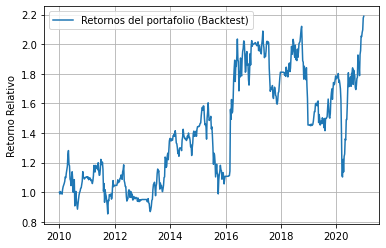

In [36]:
plt.plot(test)
plt.grid()
plt.legend(['Retornos del portafolio (Backtest)'])
plt.ylabel('Retorno Relativo');

In [20]:
y_small = getYPerf(y_) # y is cut down version of y_ with stock returns only

# Create a boolean mask for the backtest year we are interested in
date = pd.to_datetime('2015-01-01 07:00:00')
mask = y_["Date"].between( pd.to_datetime(date) - pd.Timedelta(days=60), pd.to_datetime(date) + pd.Timedelta(days=60) )
#y_[mask] # Checking the mask works
#x[mask]

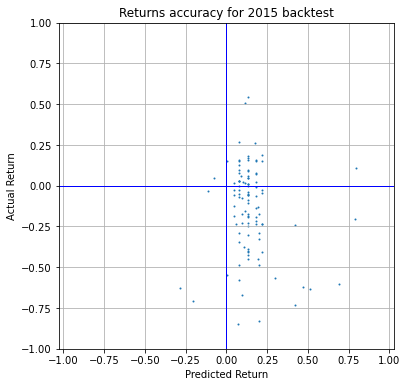

In [21]:
# Load the model pipeline
# can be pl_linear.p, pl_KNeighbors.p, pl_rfregressor.p, pl_decTree.p, pl_svm.p ...
ml_model_pipeline = pickle.load(open("pl_decTree.p", "rb" ))
y_pred = ml_model_pipeline.predict(X_test[mask]) # Get stock performance predictions
y_pred = pd.DataFrame(y_pred) # Turn into DataFrame

plt.figure(figsize=(6,6))
# Now output graph.
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
plt.scatter(y_pred[0], y_small[mask]["Perf"], s=1)
# Formatting
plt.grid()
plt.axis('equal')
plt.title('Returns accuracy for {} backtest'.format(date.year))
plt.xlabel('Predicted Return')
plt.ylabel('Actual Return')
plt.axvline(c='blue', lw=1)
plt.axhline(c='blue', lw=1)
plt.savefig('result.png')
plt.axis([-1,1,-1,1]);

In [22]:
# Top stocks picked, and predicted performance.
bl = (y_pred[0] > y_pred.nlargest(8,0).tail(1)[0].values[0])

print("\nTop predicted perf. stocks picked are:")
print(y_small[mask].reset_index(drop=True)[bl]["Ticker"])
print("\nTop stocks predicted performance is:")
print(y_pred[bl])


print("\nActual performance was: ")
print(y_small[mask].reset_index(drop=True)[bl])

# Calc Altman Z score:
Z = 3.25 \
+ 6.51 * X_test[mask].reset_index(drop=True)[bl]['(CA-CL)/TA']\
+ 3.26 * X_test[mask].reset_index(drop=True)[bl]['RE/TA']\
+ 6.72 * X_test[mask].reset_index(drop=True)[bl]['EBIT/TA']\
+ 1.05 * X_test[mask].reset_index(drop=True)[bl]['Book Equity/TL']
print('\nZ scores:\n',Z)


Top predicted perf. stocks picked are:
2     LLNW
3      RFP
32    KLIC
47    SKYW
70    NVTA
86    INFI
Name: Ticker, dtype: object

Top stocks predicted performance is:
           0
2   0.692418
3   6.372549
32  0.789583
47  0.793038
70  0.472119
86  0.511991

Actual performance was: 
   Ticker      Perf
2    LLNW -0.602007
3     RFP -0.724836
32   KLIC -0.202494
47   SKYW  0.107610
70   NVTA -0.622857
86   INFI -0.632021

Z scores:
 2      9.598341
3      4.364590
32    15.575440
47     5.267632
70    16.181678
86     5.472175
dtype: float64


In [23]:
# bool list of 7 greatest performance stocks of y_pred 
bl = (y_pred[0] > y_pred.nlargest(8,0).tail(1)[0].values[0])

# See what the performance is of the selection
print("Backtest return is:")
print(y_small[mask]["Perf"].reset_index(drop=True)[bl].values.mean())

Backtest return is:
-0.44610089047106305


In [24]:
d = getYRawData()

Reading historical time series stock data, matrix size is:  (8125701, 11)


In [25]:
# Make X ticks standard, and grab stock prices as close to those points as possible for each stock (To track performance)
date_range = pd.date_range(start=date, periods=52, freq='W')#DatetimeIndex

# 7 greatest performance stocks of y_pred 
ticker_list = y_[mask].reset_index(drop=True)[bl]["Ticker"].values
stockRet = getStockTimeSeries(date_range, y_, ticker_list , mask, daily_stock_prices)

In [26]:
stockRetRel = getPortfolioRelativeTimeSeries(stockRet)

In [27]:
stockRetRel.head()

,LLNW,RFP,KLIC,SKYW,NVTA,INFI,Portfolio
2015-01-04 07:00:00,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000
2015-01-11 07:00:00,1.0,1.0,1.011212,1.0,1.0,1.0,1.001869
2015-01-18 07:00:00,1.0,1.0,1.006307,1.0,1.0,1.0,1.001051
2015-01-25 07:00:00,1.0,1.0,1.039944,1.0,1.0,1.0,1.006657
2015-02-01 07:00:00,1.0,1.0,1.095305,1.0,1.0,1.0,1.015884


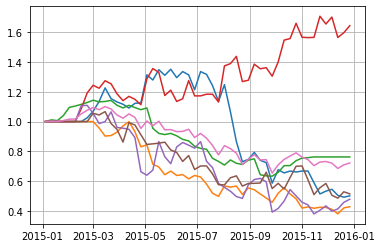

In [28]:
plt.plot(stockRetRel);
plt.grid()

# Now plot backtest with S&P500

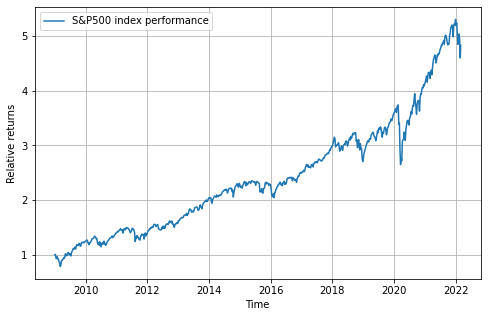

In [29]:
# GSPC.csv taken directly from Yahoo.com is the S&P500.
spy=pd.read_csv("GSPC.csv", index_col='Date', parse_dates=True)
spy['Relative'] = spy["Open"]/spy["Open"][0]

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,5))
plt.plot(spy['Relative'])
plt.grid()
plt.xlabel('Time')
plt.ylabel('Relative returns')
plt.legend(['S&P500 index performance', 'Linear Regressor Stock Picker'])

In [30]:
start_date = "2010-01-03"
end_date = "2020-12-27"

after_start_date = spy.index >= start_date
before_end_date = spy.index <= end_date
between_two_dates = after_start_date & before_end_date
filtered_dates = spy.loc[between_two_dates]

In [31]:
filtered_dates.drop(['Relative'], axis=1)

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2010-01-07,53,1136.270020,1149.739990,1131.319946,1145.680054,1145.680054,22802570000
2010-01-14,54,1145.680054,1150.449951,1129.250000,1138.040039,1138.040039,18209320000
2010-01-21,55,1138.680054,1141.579956,1083.109985,1097.500000,1097.500000,27615360000
2010-01-28,56,1096.930054,1104.729980,1071.589966,1097.280029,1097.280029,23977850000
2010-02-04,57,1097.250000,1097.250000,1044.500000,1068.130005,1068.130005,25754120000
...,...,...,...,...,...,...,...
2020-11-26,621,3638.550049,3678.449951,3594.389893,3669.010010,3669.010010,19503130000
2020-12-03,622,3668.280029,3712.389893,3657.169922,3672.820068,3672.820068,24726300000
2020-12-10,623,3659.129883,3711.270020,3633.399902,3701.169922,3701.169922,21997540000


In [32]:
filtered_dates['Relative'] = filtered_dates["Open"]/filtered_dates["Open"][0]

C:\Users\Usuario\AppData\Local\Temp/ipykernel_57376/1391807714.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dates['Relative'] = filtered_dates["Open"]/filtered_dates["Open"][0]


In [33]:
filtered_dates

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume,Relative
Date,,,,,,,,
2010-01-07,53,1136.270020,1149.739990,1131.319946,1145.680054,1145.680054,22802570000,1.000000
2010-01-14,54,1145.680054,1150.449951,1129.250000,1138.040039,1138.040039,18209320000,1.008282
2010-01-21,55,1138.680054,1141.579956,1083.109985,1097.500000,1097.500000,27615360000,1.002121
2010-01-28,56,1096.930054,1104.729980,1071.589966,1097.280029,1097.280029,23977850000,0.965378
2010-02-04,57,1097.250000,1097.250000,1044.500000,1068.130005,1068.130005,25754120000,0.965660
...,...,...,...,...,...,...,...,...
2020-11-26,621,3638.550049,3678.449951,3594.389893,3669.010010,3669.010010,19503130000,3.202188
2020-12-03,622,3668.280029,3712.389893,3657.169922,3672.820068,3672.820068,24726300000,3.228352
2020-12-10,623,3659.129883,3711.270020,3633.399902,3701.169922,3701.169922,21997540000,3.220300


In [34]:
modelo = 'Modelo Arbol de decisión'

Volatilidad Modelo:  0.40402949312538944
Volatilidad S&P 500:  0.3131362579812779
Retorno modelo:   118.85787829357261 %
Retorno S&P 500:   225.10142518765042 %


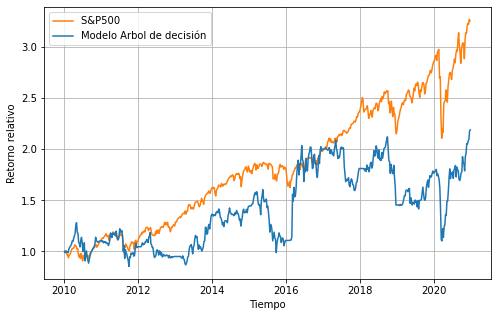

In [35]:
plt.figure(figsize=(8,5))
plt.plot(filtered_dates['Relative'], color='C1')
plt.plot(test["Indexed Performance"], color='C0')
plt.legend(['S&P500 ', modelo])
plt.xlabel('Tiempo')
plt.ylabel('Retorno relativo')
plt.grid()
print('Volatilidad Modelo: ', test['Indexed Performance'].diff().std()*np.sqrt(52))
print('Volatilidad S&P 500: ', filtered_dates['Relative'].diff().std()*np.sqrt(52))
print('Retorno modelo:  ', 100 * (test["Indexed Performance"][-1]-1), '%')
print('Retorno S&P 500:  ', 100 * (filtered_dates["Relative"][-1]-1), '%')

In [38]:
test.to_csv("filtered_dates_DTREES.csv")